# Разработка A/B-тестирования и анализ результатов

## Описание данных

**Представлены 3 таблицы:**

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать

**Задачи:** рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных

In [1]:
# Импортируем все нужные библиотеки для дальнейшей работы с данными
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from math import ceil
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Создаем датафрейм с историческими данными
sessions_history = pd.read_csv('/datasets/sessions_project_history.csv')

In [3]:
# Выводим первые 5 строк датафрейма
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитать количество уникальных сессий `session_id`.

- Вывод на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий.

- Изучить таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.


In [4]:
# Считаем уникальное кол-во сессий для каждого пользователя
unique_sessions = sessions_history.groupby('user_id')['session_id'].nunique().reset_index()
unique_sessions.columns = ['user_id', 'unique_session_count']

display(unique_sessions)

,user_id,unique_session_count
0,00005FB6A13A6FBE,2
1,0000B15A18D77ED9,3
2,0000C4E3A4A571A9,2
3,000293FAF9E67A81,4
4,00029C5AE889A6C3,2
...,...,...
134034,FFFCDE7746148710,4
134035,FFFDD413285E753F,3
134036,FFFECBA0F2578AB0,2
134037,FFFEDB68228B5F21,5


In [5]:
# Находим пользователя с максимальным кол-вом сессий и выводим всю информацию о нем
max_user = unique_sessions.loc[unique_sessions['unique_session_count'].idxmax()]
user_sessions = sessions_history[sessions_history['user_id'] == max_user['user_id']]

display(user_sessions)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. 

- Агрегировать исторические данные и рассчитать число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения.

- Построить линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням.

- Построить отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

In [6]:
# Создадим таблицу только с кол-вом уникальных пользователей и кол-вом зарегистрированных пользователей для каждой даты
users_reg = sessions_history.groupby('session_date').agg(unique_users=('user_id', 'nunique'),
    registered_users=('registration_flag', lambda x: (x == 1).sum())
).reset_index()

display(users_reg)

,session_date,unique_users,registered_users
0,2025-08-11,3919,169
1,2025-08-12,6056,336
2,2025-08-13,8489,464
3,2025-08-14,10321,625
4,2025-08-15,14065,840
5,2025-08-16,12205,916
6,2025-08-17,11200,833
7,2025-08-18,10839,860
8,2025-08-19,12118,831
9,2025-08-20,13514,1008


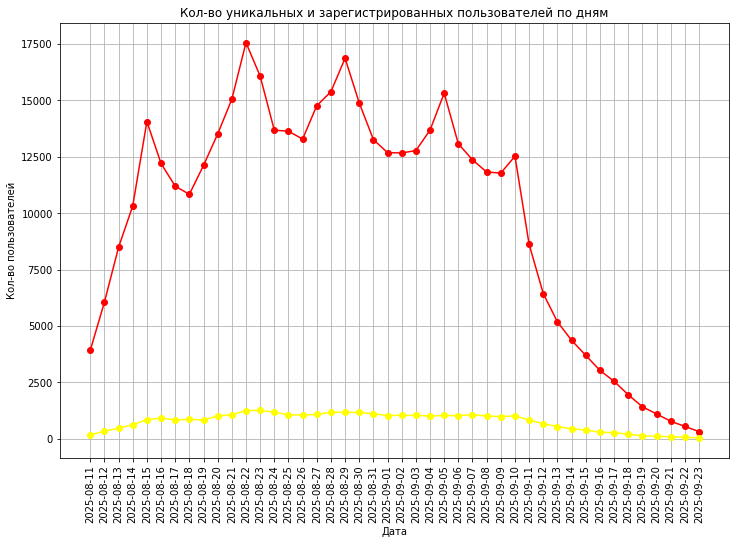

In [7]:
# Визуализируем полученные данные
plt.figure(figsize=(12, 8))
plt.plot(users_reg['session_date'], users_reg['unique_users'], marker='o', label='Общее кол-во уникальных пользователей', color='red')
plt.plot(users_reg['session_date'], users_reg['registered_users'], marker='o', label='Общее кол-во зарегистрированных пользователей', color='yellow')

plt.title('Кол-во уникальных и зарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Кол-во пользователей')
plt.xticks(rotation=90)
plt.legend
plt.grid(True)

plt.show()

In [8]:
# Считаем долю зарегистрированных пользователей
users_reg['registered_part'] = users_reg['registered_users'] / users_reg['unique_users']

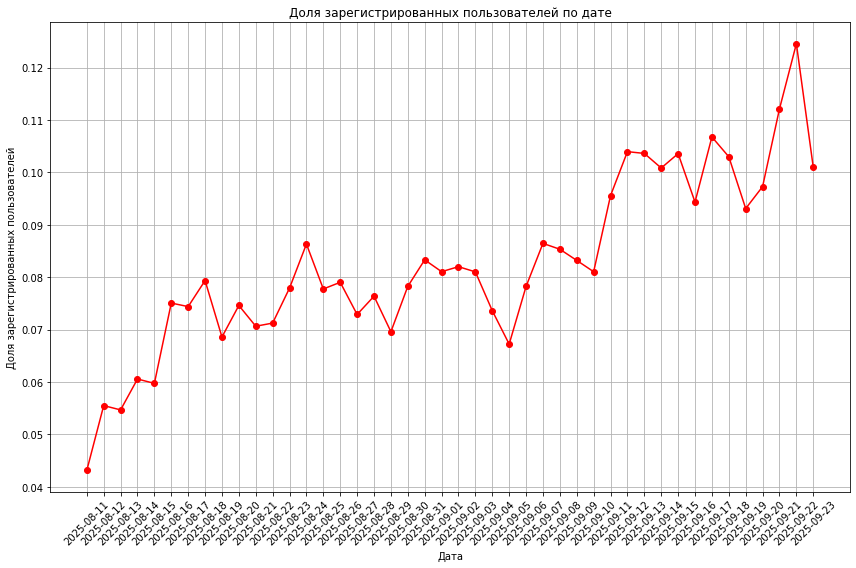

In [9]:
plt.figure(figsize=(12, 8))
plt.plot(users_reg['session_date'], users_reg['registered_part'], marker='o', color='red')
plt.title('Доля зарегистрированных пользователей по дате')
plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных пользователей')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

**Вывод:** По результатам анализа числа регистраций можем отметить, что наблюдается активный рост доли зарегистрированных пользователей. Он достигает своего пика 22.09.2025 и далее идет на спад. Но также, мы можем отметить, что с 10.09.2025 наблюдается резкий спад уникальных пользователей.

#### 1.4. Анализ числа просмотренных страниц
- Найти количество сессий для каждого значения количества просмотренных страниц.

- Построить столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

In [10]:
# Считаем кол-во сессий для каждого значения кол-ва просмотренных страниц
session_counts = sessions_history.groupby('page_counter')['session_id'].count().reset_index()
session_counts.columns = ['page_counter', 'session_count']

display(session_counts)

,page_counter,session_count
0,1,29160
1,2,105536
2,3,166690
3,4,105569
4,5,26288
5,6,2589
6,7,92


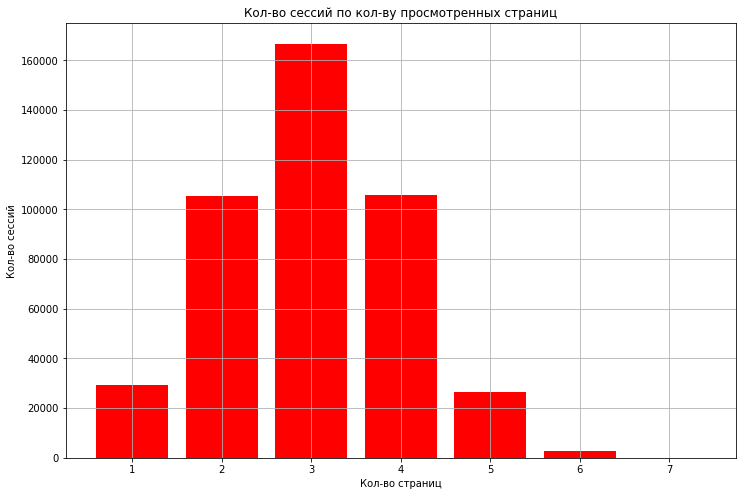

In [11]:
# Построим диаграмму на основе полученных данных
plt.figure(figsize=(12, 8))
plt.bar(session_counts['page_counter'], session_counts['session_count'], color='red')
plt.xlabel('Кол-во страниц')
plt.ylabel('Кол-во сессий')
plt.title('Кол-во сессий по кол-ву просмотренных страниц')
plt.grid(True)

plt.show()

In [12]:
# Создаем новый столбец
sessions_history['good_session'] = (sessions_history['page_counter'] >= 4).astype(int)

display(sessions_history.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,good_session
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone,0
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android,1
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC,1
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android,1
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android,0


In [13]:
# Считаем среднее значение доли успешных сессий по дням
daily_success_rate = sessions_history.groupby('session_date')['good_session'].mean().reset_index()
daily_success_rate.columns = ['date', 'success_rate']

display(daily_success_rate)

,date,success_rate
0,2025-08-11,0.312835
1,2025-08-12,0.302015
2,2025-08-13,0.306750
3,2025-08-14,0.316055
4,2025-08-15,0.304941
5,2025-08-16,0.306186
6,2025-08-17,0.317589
7,2025-08-18,0.310545
8,2025-08-19,0.312840
9,2025-08-20,0.306941


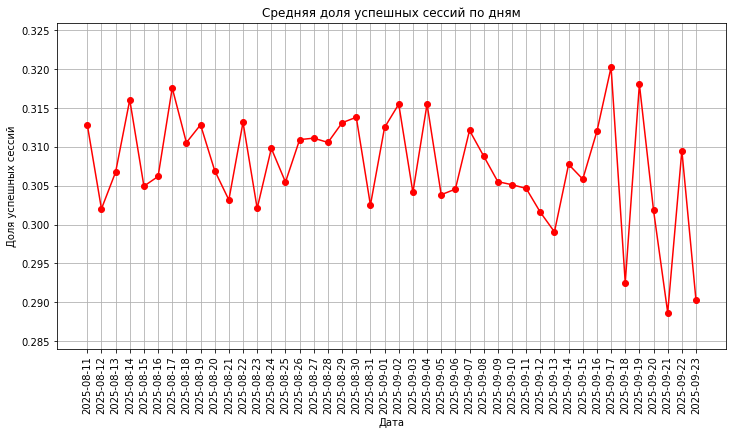

In [14]:
# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(daily_success_rate['date'], daily_success_rate['success_rate'], marker='o', color='red')
plt.title('Средняя доля успешных сессий по дням')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.xticks(rotation=90)
plt.ylim(0.284, 0.326)
plt.grid(True)
plt.show()

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

#### 2.1 Формулировка нулевой и альтернативной гипотез

Целевая метрика - Conversion Rate. Если алгоритмы рекомендательных систем улучшатся, то ожидается, что пользователи будут выполнять какие-то действия по рекомендации в большем объеме. Следовательно, речь о конверции.

**Нулевая гипотеза:** Доля успешных сессий в тестовой группе B меньше, чем в контрольной группе A, или равна ей.

**Альтернативная гипотеза:** Доля успешных сессий в тестовой группе B больше, чем в контрольной группе A.

#### 2.2. Расчёт размера выборки

In [15]:
# Задаём параметры
alpha = 0.05 # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
p1 = 0.3 # Базовый уровень доли
mde = 0.03 * p1  # Минимальный детектируемый эффект
p2 = p1 + mde
effect_size = proportion_effectsize(p1, p1 + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


#### 2.3. Расчёт длительности A/B-теста
- Рассчитать среднее количество уникальных пользователей приложения в день.

- Определить длительность теста исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения.

In [16]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = sessions_history.groupby('session_date')['user_id'].nunique()
avg_daily_users = avg_daily_users.mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size * 2 / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.363636363636 пользователей в день составит 9 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие метрики корректно считаются.

- Рассчитать количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитать и выведите на экран процентную разницу в количестве пользователей в группах A и B.

In [17]:
# Создаем новый датафрейм
sessions_test_part = pd.read_csv('/datasets/sessions_project_test_part.csv')

display(sessions_test_part)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B
...,...,...,...,...,...,...,...,...,...,...,...
3125,02A3BA5F727BC3C9,7D4427384463A16E,2025-10-14,2025-10-14 14:52:26,2025-10-14,1,0,4,MENA,Android,B
3126,A7E51F39427F03A5,290910138655DD03,2025-10-14,2025-10-14 19:15:18,2025-10-14,1,0,2,CIS,PC,B
3127,78DDBD077D61EEDB,C10E073BFF1FAF0C,2025-10-14,2025-10-14 16:07:20,2025-10-14,1,0,2,EU,iPhone,B
3128,B44E0A30E8ED1AFC,7B404F7021711E5D,2025-10-14,2025-10-14 17:41:01,2025-10-14,1,0,3,EU,Mac,B


In [18]:
# Считаем кол-во уникальных пользователей для каждой группы
users_group_ab = sessions_test_part.groupby('test_group')['user_id'].nunique()

display(users_group_ab)

test_group
A    1477
B    1466
Name: user_id, dtype: int64

In [19]:
# Рассчитаем процентную разницу в количестве пользователей в группах A и B
A = users_group_ab['A']
B = users_group_ab['B']

percent_difference = 100 * abs(A - B) / A

display(percent_difference)

0.7447528774542993

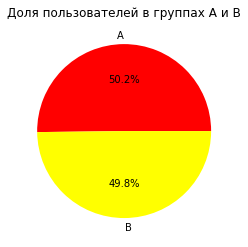

In [20]:
# Создаем визуализацию для наглядности в различии групп А и В
groups = list(users_group_ab.keys())
values = users_group_ab.values

plt.pie(values, labels=groups, autopct='%1.1f%%', colors=['red', 'yellow'])
plt.title('Доля пользователей в группах A и B')
plt.show()

#### 3.2. Проверка пересечений пользователей
- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [21]:
# Ищем пересечение пользователей A и B
users_A = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].unique()
users_B = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].unique()

common_users = set(users_A) & set(users_B)

common_user_count = len(common_users)

print(f'Количество пользователей, которые встречаются одновременно в группах A и B: {common_user_count}')

Количество пользователей, которые встречаются одновременно в группах A и B: 0


#### 3.3. Равномерность разделения пользователей по устройствам
Построить две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

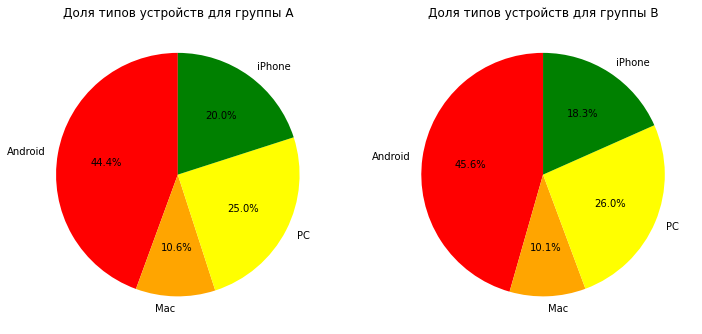

In [22]:
# Строим диаграммы для каждого региона в группах А и В
group_A = sessions_test_part[sessions_test_part['test_group'] == 'A']
group_B = sessions_test_part[sessions_test_part['test_group'] == 'B']

device_count_A = group_A.groupby('device')['user_id'].nunique()
device_count_B = group_B.groupby('device')['user_id'].nunique()


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
colors_device = ['red', 'orange', 'yellow', 'green']

# Диаграмма для группы А
device_count_A.plot(kind='pie', ax=axes[0], autopct='%1.1f%%', startangle=90, colors=colors_device)
axes[0].set_title('Доля типов устройств для группы A')
axes[0].set_ylabel('')

# Диаграмма для группы B
device_count_B.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=90, colors=colors_device)
axes[1].set_title('Доля типов устройств для группы B')
axes[1].set_ylabel('')

plt.show()

#### 3.4. Равномерность распределения пользователей по регионам
Построить две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

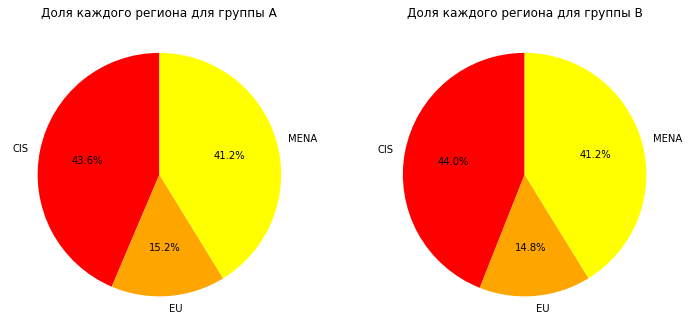

In [23]:
# Строим диаграммы для каждого типа устройств в группах А и В
group_A = sessions_test_part[sessions_test_part['test_group'] == 'A']
group_B = sessions_test_part[sessions_test_part['test_group'] == 'B']

region_count_A = group_A.groupby('region')['user_id'].nunique()
region_count_B = group_B.groupby('region')['user_id'].nunique()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
colors_region = ['red', 'orange', 'yellow']

# Диаграмма для группы А
region_count_A.plot(kind='pie', ax=axes[0], autopct='%1.1f%%', startangle=90, colors=colors_region)
axes[0].set_title('Доля каждого региона для группы A')
axes[0].set_ylabel('')

# Диаграмма для группы B
region_count_B.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=90, colors=colors_region)
axes[1].set_title('Доля каждого региона для группы B')
axes[1].set_ylabel('')

plt.show()

#### 3.5. Вывод после проверки A/B-теста

**Вывод:** По итогам A/B-теста было обнаружно небольшое различие в размерах групп А и В. Выборки являются независимыми, так как пересечений в пользователях не обнаружно. Распредление в группах по регионам и устройствам равномерное с небольшими погрешностями.

### 4. Проверка результатов A/B-теста

#### 4.1. Получение результатов теста и подсчёт основной метрики

In [24]:
# Создаем новый датафрейм
sessions_test = pd.read_csv('/datasets/sessions_project_test.csv')

display(sessions_test)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B
...,...,...,...,...,...,...,...,...,...,...,...
100000,CF77C27B238C1BE3,0F7BC9B33685377C,2025-10-22,2025-10-22 19:01:50,2025-10-20,3,0,3,MENA,Android,A
100001,D7ED66C581409AC2,26C4475005E70F47,2025-10-17,2025-10-17 22:12:38,2025-10-17,1,0,5,CIS,PC,A
100002,E7EA2D51238020C6,9B9CDE6A612CBD73,2025-10-24,2025-10-24 14:54:07,2025-10-14,2,0,3,MENA,PC,B
100003,8A6FEFD7F34C5DA1,37291EC27106EF9D,2025-10-18,2025-10-18 00:05:10,2025-10-14,3,0,4,EU,Android,B


In [25]:
# Создаем новый столбец в датафрейме
sessions_test['good_session'] = (sessions_test['page_counter'] >= 4).astype(int)

display(sessions_test)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0
...,...,...,...,...,...,...,...,...,...,...,...,...
100000,CF77C27B238C1BE3,0F7BC9B33685377C,2025-10-22,2025-10-22 19:01:50,2025-10-20,3,0,3,MENA,Android,A,0
100001,D7ED66C581409AC2,26C4475005E70F47,2025-10-17,2025-10-17 22:12:38,2025-10-17,1,0,5,CIS,PC,A,1
100002,E7EA2D51238020C6,9B9CDE6A612CBD73,2025-10-24,2025-10-24 14:54:07,2025-10-14,2,0,3,MENA,PC,B,0
100003,8A6FEFD7F34C5DA1,37291EC27106EF9D,2025-10-18,2025-10-18 00:05:10,2025-10-14,3,0,4,EU,Android,B,1


#### 4.2. Проверка корректности результатов теста
- Рассчитать количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверить, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми.

In [26]:
# Посчитаем кол-во уникальных сессий для каждого дня и обеих тестовых групп
test_group_a = sessions_test[sessions_test['test_group'] == 'A']
test_group_b = sessions_test[sessions_test['test_group'] == 'B']

uniq_session_a = test_group_a.groupby('session_date')['session_id'].nunique()
uniq_session_b = test_group_b.groupby('session_date')['session_id'].nunique()

display(uniq_session_a, uniq_session_b)

session_date
2025-10-14    1502
2025-10-15    2235
2025-10-16    3280
2025-10-17    4089
2025-10-18    5013
2025-10-19    6535
2025-10-20    5837
2025-10-21    3927
2025-10-22    3083
2025-10-23    2470
2025-10-24    2090
2025-10-25    1897
2025-10-26    1669
2025-10-27    1454
2025-10-28    1279
2025-10-29    1068
2025-10-30     887
2025-10-31     644
2025-11-01     434
2025-11-02     158
Name: session_id, dtype: int64

session_date
2025-10-14    1628
2025-10-15    2283
2025-10-16    3241
2025-10-17    4054
2025-10-18    5059
2025-10-19    6779
2025-10-20    6089
2025-10-21    3981
2025-10-22    3111
2025-10-23    2548
2025-10-24    2068
2025-10-25    1814
2025-10-26    1692
2025-10-27    1517
2025-10-28    1289
2025-10-29    1131
2025-10-30     876
2025-10-31     669
2025-11-01     465
2025-11-02     160
Name: session_id, dtype: int64

In [27]:
# Проведем статистический t-тест
sessions_a = uniq_session_a.values
sessions_b = uniq_session_b.values

t_stat, p_value = stats.ttest_ind(sessions_a, sessions_b)

print(f'p-value={p_value}')

alpha = 0.05
if p_value > alpha:
    print('Различия статистически не значительны (принимаем нулевую гипотезу)')
else:
    print('Различия статистически значительны (отклоняем нулевую гипотезу)')
   

p-value=0.938219304859116
Различия статистически не значительны (принимаем нулевую гипотезу)


#### 4.3. Сравнение доли успешных сессий

In [28]:
# Рассчитываем долю успешных сессий для группы A
total_sessions_a = len(test_group_a)
successful_sessions_a = test_group_a['good_session'].sum()
success_rate_a = successful_sessions_a / total_sessions_a

print(f"Доля успешных сессий для группы A: {success_rate_a:.4f}")

Доля успешных сессий для группы A: 0.3077


In [29]:
# Рассчитываем долю успешных сессий для группы B
total_sessions_b = len(test_group_b)
successful_sessions_b = test_group_b['good_session'].sum()
success_rate_b = successful_sessions_b / total_sessions_b

print(f"Доля успешных сессий для группы B: {success_rate_b:.4f}")

Доля успешных сессий для группы B: 0.3183


In [30]:
# Рассчитываем разницу в доле успешных сессий
difference = success_rate_b - success_rate_a

print(f"Разница в доле успешных сессий: {difference:.4f}")

Разница в доле успешных сессий: 0.0106


#### 4.4. Насколько статистически значимо изменение ключевой метрики
- Рассчитать, является ли изменение в метрике доли успешных сессий статистически значимым.

In [31]:
# Рассчитываем статистическую значимость с помощью статистического теста
successes_ses = [test_group_a['good_session'].sum(), test_group_b['good_session'].sum()]
count_ses = [len(test_group_a), len(test_group_b)]

z_stat, p_value = proportions_ztest(successes_ses, count_ses)

print(f'p_value={p_value}')

if p_value < 0.05:
    print('Изменение в метрике доли успешных сессий является статистически значимым (принимаем нулевую гипотезу)')
else:
    print('Изменение в метрике доли успешных сессий не является статистически значимым (отклоняем нулевую гипотезу)')

p_value=0.0003149479976072246
Изменение в метрике доли успешных сессий является статистически значимым (принимаем нулевую гипотезу)


#### 4.5. Вывод по результатам A/B-эксперимента

**Вывод:** 
1. Во время A/B-эксперимента задействованы 1477 пользователей в группе А и 1466 пользователей в группе В. Эксперимент длился 1 день. В эксперменте были задействованы пользователей из 3-х регионов и, также, учитывались 4 вида устройств.
2. Исходя из расчетов, можем сделать вывод, что введение новых алгоритмов не повлияло на активность пользователей. Доля активности увеличилась на 1%, что, исходя из расчета p-value не явлется значимым результатом. Следовательно, принимаем нулевую гипотезу.
3. По результатам расчетов p_value=0.0003149479976072289.
4. Нововведение не стоит внедрять.